In [1]:
from nanovna import NanoVNA
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
def gamma_transfer_func(S11_here, S12_here, S21_here, S22_here, Gamma_here):
    Gamma_prime_here = S11_here + ( S12_here * S21_here * Gamma_here/(1 - S22_here*Gamma_here))
    return Gamma_prime_here

def de_embed(S11_here, Diff_here, S22_here, Gamma_prime_here):
    Gamma_here = (Gamma_prime_here - S11_here)/(Diff_here + S22_here*Gamma_prime_here)
    return Gamma_here

def de_embed_DUT(Gamma_DUT):
    pickle_in = open('cal_coeffs.pkl',"rb")
    cal_coeff = pickle.load(pickle_in)
    
    EDF_array = cal_coeff['EDF'] 
    diff_array = cal_coeff['diff'] 
    ESF_array = cal_coeff['ESF']
    Gamma_DUT_cal = de_embed(EDF_array, diff_array, ESF_array, Gamma_DUT) 
    return Gamma_DUT_cal

def cal_coeff_compute(dataset):
    freq = dataset['freq']
    Gamma_open = dataset['Open']
    Gamma_short = dataset['Short']
    Gamma_load = dataset['Load']
    
    EDF_array = np.zeros(len(freq), dtype=np.complex64)
    ESF_array = np.zeros(len(freq), dtype=np.complex64)
    diff_array = np.zeros(len(freq), dtype=np.complex64)
    
    # Let us assume the models as follows
    Gamma_open_model = 1.0
    Gamma_short_model = -1.0
    Gamma_load_model = 0.00
    
    for i in range(len(freq)):

        # We will try to recover the S params of the RP now.
        Measure_matrix = np.array([[1, Gamma_open_model, Gamma_open_model*Gamma_open[i]],
                                    [1, Gamma_short_model, Gamma_short_model*Gamma_short[i]],
                                    [1, Gamma_load_model, Gamma_load_model*Gamma_load[i]]])

        Gamma_matrix_measu = np.array([Gamma_open[i], Gamma_short[i], Gamma_load[i]])

        reco_para = np.matmul(np.linalg.inv(Measure_matrix), Gamma_matrix_measu)

        EDF_array[i] = reco_para[0]
        diff_array[i] = reco_para[1]
        ESF_array[i] = reco_para[2]
        
    my_data_dict = {}
    my_data_dict['EDF'] = EDF_array
    my_data_dict['ESF'] = ESF_array
    my_data_dict['diff'] = diff_array
    
    file_out = 'cal_coeffs.pkl'
    f = open(file_out,"wb")
    pickle.dump(my_data_dict,f)
    f.close()

In [3]:
def acq():
    nv = NanoVNA()
    print ("Connect open")
    nv.set_sweep(50e6, 200e6)
    nv.fetch_frequencies()
    freq = nv.frequencies
    Gamma_open = nv.data(0)

In [4]:
# nv = NanoVNA()

In [5]:
# filename = "long_cable.txt"
# nv.set_sweep(50e6, 200e6)
# nv.fetch_frequencies()
# freq = nv.frequencies

In [6]:
# s11 = nv.data(0)
# plt.plot(freq, np.real(s11))
# plt.plot(freq, np.imag(s11))
# np.savetxt(filename, np.column_stack([freq, np.real(s11), np.imag(s11)]))

In [7]:
freq = np.loadtxt("Open.txt", usecols=0)
Gamma_open = np.loadtxt("Open.txt", usecols=1)+np.loadtxt("Open.txt", usecols=2)*1j
Gamma_short = np.loadtxt("Short.txt", usecols=1)+np.loadtxt("Short.txt", usecols=2)*1j
Gamma_load = np.loadtxt("Load.txt", usecols=1)+np.loadtxt("Load.txt", usecols=2)*1j
Gamma_DUT = np.loadtxt("long_cable.txt", usecols=1)+np.loadtxt("long_cable.txt", usecols=2)*1j

data_now = {}
data_now['freq'] = freq
data_now['Open'] = Gamma_open
data_now['Short'] = Gamma_short 
data_now['Load'] = Gamma_load

cal_coeff_compute(data_now)

Gamma_DUT_cal = de_embed_DUT(Gamma_DUT) 

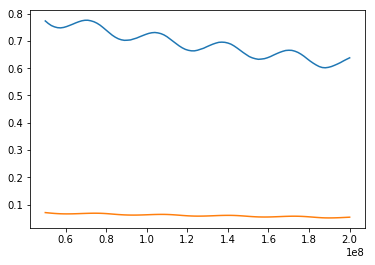

In [8]:
plt.plot(freq, np.abs(Gamma_DUT_cal))
plt.plot(freq, np.abs(Gamma_DUT))